# ML Pipeline

In [19]:
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *
import pandas as pd
import matplotlib.pyplot as plt
from snowflake.snowpark.functions import udf
%matplotlib inline
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
from config import snowflake_conn_prop

session = Session.builder.configs(snowflake_conn_prop).create()
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

[Row(CURRENT_WAREHOUSE()='TEST_WH', CURRENT_DATABASE()='SNOWPARK_QUICKSTART', CURRENT_SCHEMA()='TELCO')]


In [3]:
%%time
raw = session.table('TRAIN_DATASET').sample(n=40000)
data = raw.toPandas()

CPU times: user 877 ms, sys: 66.7 ms, total: 944 ms
Wall time: 6.13 s


## Separate dataset into train / test

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['CHURNVALUE', 'CUSTOMERID'], axis=1),
    data['CHURNVALUE'],
    test_size=0.2,
    random_state=0
)

X_train.shape, X_test.shape

((32000, 20), (8000, 20))

In [7]:
categorical = ['GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE',
            'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES',
            'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD']

numerical = [ 'TENUREMONTHS', 'MONTHLYCHARGES', 'TOTALCHARGES']
features = categorical + numerical
print(features)

['GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE', 'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES', 'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD', 'TENUREMONTHS', 'MONTHLYCHARGES', 'TOTALCHARGES']


## Variable transformation

- 가우시안 분포에 가깝게 만들기 위해 MinMaxScaler 적용
- categorical variable에 ordinal encoding 적용

### check missing values

In [9]:
print([var for var in X_train.columns if X_train[var].isnull().sum() > 0])
print([var for var in X_test.columns if X_test[var].isnull().sum() > 0])

[]
[]


In [10]:
#transformations
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

#Classifier
from sklearn.ensemble import RandomForestClassifier

#Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

#Model Accuracy
from sklearn.metrics import balanced_accuracy_score

ord_pipe = make_pipeline(
    FunctionTransformer(lambda x: x.astype(str)),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
)

num_pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0),
    MinMaxScaler()
)

clf = make_pipeline(RandomForestClassifier(random_state=0, n_jobs=-1))

model = make_pipeline(ord_pipe, num_pipe, clf)

model.fit(X_train, y_train)

Pipeline(steps=[('pipeline-1',
                 Pipeline(steps=[('functiontransformer',
                                  FunctionTransformer(func=<function <lambda> at 0x7fdffe575790>)),
                                 ('ordinalencoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=-1))])),
                ('pipeline-2',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant')),
                                 ('minmaxscaler', MinMaxScaler())])),
                ('pipeline-3',
                 Pipeline(steps=[('randomforestclassifier',
                                  RandomForestClassifier(n_jobs=-1,
                                                         random_state=0))]))])

## Check Accuracy on test dataset

In [11]:
y_pred = model.predict_proba(X_test)[:,1]
predictions = [round(value) for value in y_pred]
balanced_accuracy = balanced_accuracy_score(y_test, predictions)
print("Model testing completed. Accuracy: %.2f%%" % (balanced_accuracy * 100.0))

Model testing completed. Accuracy: 99.40%


## Confusion Matrix

In [12]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)
TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP) : ', TP)
print('False Positive(FP) : ', FP)
print('True Negative(TN) : ', TN)
print('False Negative(FN) : ', FN)

accuracy = (TP+TN) / (TP+FP+FN+TN)
print('Accuracy of classification : {:0.3f}'.format(accuracy))

True Positive(TP) :  2516
False Positive(FP) :  18
True Negative(TN) :  5444
False Negative(FN) :  22
Accuracy of classification : 0.995


## Check important features

Text(0.5, 0, 'Feature Importance')

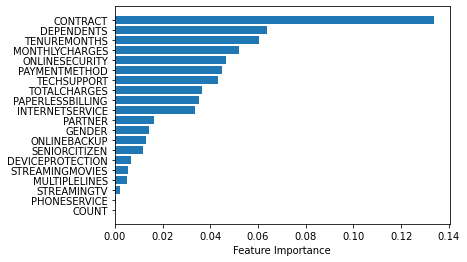

In [14]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(np.array(X_test.columns)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Feature Importance")

## Model deployment in snowflake using Snowpark python UDF
score live data

In [15]:
print(session.sql('create stage if not exists MODELSTAGE').collect())

[Row(status='Stage area MODELSTAGE successfully created.')]


### prediction UDF for deployment

In [17]:
%%time 
features = list(X_train.columns)

session.add_packages("scikit-learn==1.0.2", "pandas", "numpy")

@udf(name='predict_churn', is_permanent=True, stage_location='@MODELSTAGE', replace=True)
def predict_churn(args:list) -> float:
    row = pd.DataFrame([args], columns=features)
    return model.predict(row)

CPU times: user 1.45 s, sys: 115 ms, total: 1.57 s
Wall time: 39.3 s


OR

In [22]:
session.add_packages("scikit-learn==1.0.2", "pandas", "numpy")
features = list(X_train.columns)
predict_churn_model = session.udf.register(lambda *args:
                                    model.predict(pd.DataFrame(args, columns=features)),
                                    name='predict_churn_model',
                                    stage_location="@MODELSTAGE",
                                    return_type=FloatType(),
                                    is_permanent=True,
                                    replace=True,
                                    input_tyeps=[ArrayType()]
                            )

### Get predictions for new data

In [18]:
new_df = session.table('TRAIN_DATASET').sample(n=400)

In [20]:
%%time
new_df.select(new_df.CUSTOMERID, new_df.CHURNVALUE,
              F.call_udf("predict_churn", F.array_construct(*features)).alias('PREDICTED_CHURN')
              ).write.mode('overwrite').saveAsTable('churn_detection')

CPU times: user 6.83 ms, sys: 2.48 ms, total: 9.31 ms
Wall time: 41.4 s


In [24]:
%%time
session.table('churn_detection').toPandas()

CPU times: user 6.57 ms, sys: 2.61 ms, total: 9.19 ms
Wall time: 309 ms


,CUSTOMERID,CHURNVALUE,PREDICTED_CHURN
0,5859-I4Myz,1.0,1.0
1,9790-7jCbU,1.0,1.0
2,8745-GiIWj,0.0,0.0
3,7264-7Im5e,1.0,1.0
4,8239-SwtDL,0.0,0.0
...,...,...,...
395,1795-AcHDM,0.0,0.0
396,5264-zLOl7,1.0,1.0
397,7811-Idu28,1.0,1.0
398,5093-soyMn,0.0,0.0


OR with SQL

In [23]:
%%time
session.sql('select customerid, churnvalue, \
                predict_churn(ARRAY_CONSTRUCT( \
                                    GENDER, \
                                    COUNT, \
                                    SENIORCITIZEN, \
                                    PARTNER, \
                                    DEPENDENTS, \
                                    PHONESERVICE, \
                                    MULTIPLELINES,  \
                                    INTERNETSERVICE,  \
                                    ONLINESECURITY,  \
                                    ONLINEBACKUP, \
                                    DEVICEPROTECTION,  \
                                    TECHSUPPORT,  \
                                    STREAMINGTV,  \
                                    STREAMINGMOVIES, \
                                    CONTRACT,  \
                                    PAPERLESSBILLING,  \
                                    PAYMENTMETHOD,  \
                                    TENUREMONTHS, \
                                    MONTHLYCHARGES,  \
                                    TOTALCHARGES)) as Churn_prediction \
            from train_dataset sample (10 rows)').show()

----------------------------------------------------
|"CUSTOMERID"  |"CHURNVALUE"  |"CHURN_PREDICTION"  |
----------------------------------------------------
|9102-Bjmev    |0.0           |0.0                 |
|7207-OV5ag    |1.0           |0.0                 |
|6091-GivFr    |0.0           |0.0                 |
|3337-54vlf    |0.0           |1.0                 |
|6533-4T5CH    |1.0           |0.0                 |
|1352-28a2d    |0.0           |0.0                 |
|8099-Vl1BN    |0.0           |0.0                 |
|5825-COZRz    |0.0           |0.0                 |
|2350-0DSib    |0.0           |0.0                 |
|8883-IeD6x    |0.0           |1.0                 |
----------------------------------------------------

CPU times: user 158 ms, sys: 4.31 ms, total: 162 ms
Wall time: 5.71 s
